# QuantAgent 演示：股票数据获取与可视化

本 Notebook 旨在演示如何通过 Tushare API 获取指定股票的 OHLCV 数据，并生成交互式图表和统计表格。这些输出可以直接截图或导出，用于 PowerPoint 展示。

In [9]:
# 1. 导入必要的库
import sys
import os

# 将项目根目录添加到路径，以便导入配置
sys.path.append(os.path.abspath(".."))

import tushare as ts
import pandas as pd
import mplfinance as mpf
from config.settings import TUSHARE_TOKEN

print("Libraries imported successfully.")

Libraries imported successfully.


In [10]:
# 2. 初始化 Tushare Pro 接口
# 使用配置文件中的 Token
ts.set_token(TUSHARE_TOKEN)
pro = ts.pro_api()

print(f"Tushare initialized with token: {TUSHARE_TOKEN[:6]}******")

Tushare initialized with token: d47f91******


In [11]:
# 3. 定义获取股票数据的函数
def get_stock_ohlcv(ts_code, start_date, end_date):
    """
    获取指定股票的日线行情数据
    :param ts_code: 股票代码 (e.g., '600519.SH')
    :param start_date: 开始日期 (YYYYMMDD)
    :param end_date: 结束日期 (YYYYMMDD)
    :return: DataFrame with OHLCV data
    """
    df = pro.daily(ts_code=ts_code, start_date=start_date, end_date=end_date)
    if df.empty:
        print(f"No data found for {ts_code}")
        return None
    
    # 数据预处理
    df = df.sort_values('trade_date')
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df.set_index('trade_date', inplace=True)
    
    # 重命名列以符合 mplfinance 要求
    df = df.rename(columns={
        'vol': 'volume'
    })
    
    return df[['open', 'high', 'low', 'close', 'volume']]

print("Function defined.")

Function defined.


In [12]:
# 4. 获取指定股票的 OHLCV 数据
# 示例：贵州茅台 (600519.SH) 近半年的数据
ts_code = '600519.SH'
start_date = '20240601'
end_date = '20241201'

df = get_stock_ohlcv(ts_code, start_date, end_date)

if df is not None:
    print(f"Data retrieved for {ts_code}. Shape: {df.shape}")
    display(df.head())
    display(df.tail())

Data retrieved for 600519.SH. Shape: (122, 5)


,open,high,low,close,volume
trade_date,,,,,
2024-06-03,1650.00,1650.92,1635.11,1639.39,30261.05
2024-06-04,1640.50,1656.00,1636.55,1653.20,20841.08
2024-06-05,1652.00,1658.68,1643.03,1644.00,19055.57
2024-06-06,1643.66,1651.99,1635.91,1639.81,25610.05
2024-06-07,1646.13,1646.18,1619.01,1619.18,33524.55


,open,high,low,close,volume
trade_date,,,,,
2024-11-25,1511.00,1532.00,1496.67,1498.57,33185.56
2024-11-26,1498.57,1518.88,1488.88,1509.00,25744.79
2024-11-27,1509.00,1522.15,1505.00,1519.05,25934.17
2024-11-28,1522.00,1524.99,1502.00,1518.00,23952.03
2024-11-29,1517.00,1555.00,1513.21,1525.74,36088.10


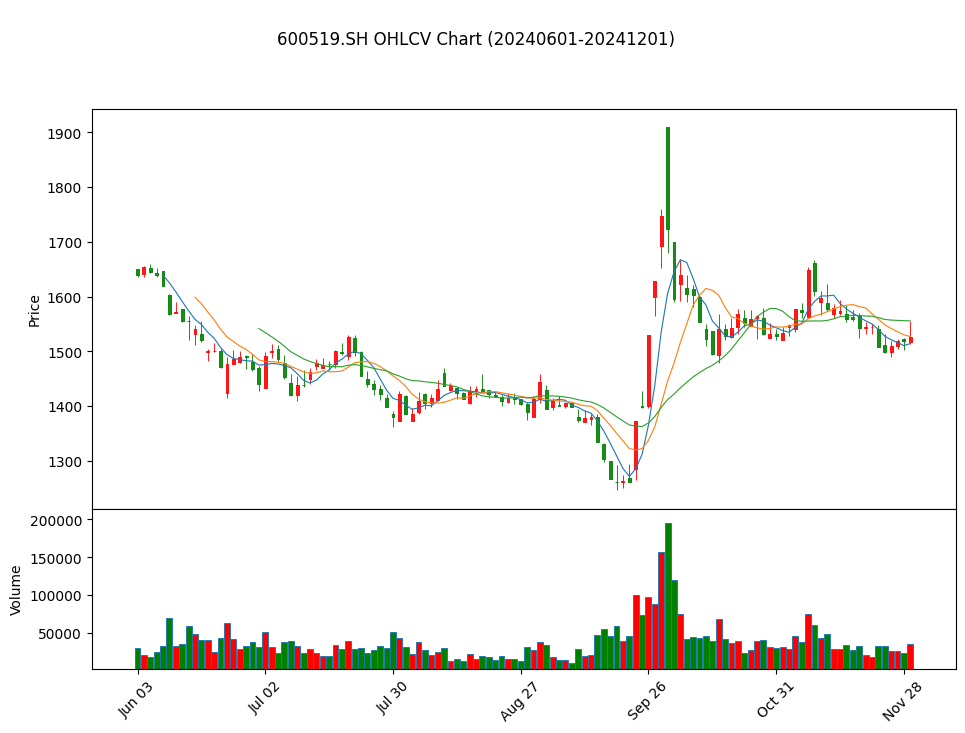

In [13]:
# 5. 绘制 K 线图 (Candlestick Chart)
# 使用 mplfinance 绘制专业的金融图表
if df is not None:
    # 设置图表样式
    mc = mpf.make_marketcolors(up='r', down='g', edge='i', wick='i', volume='in', inherit=True)
    s = mpf.make_mpf_style(marketcolors=mc)

    # 绘制图表
    mpf.plot(df, 
             type='candle', 
             mav=(5, 10, 20), 
             volume=True, 
             title=f'\n{ts_code} OHLCV Chart ({start_date}-{end_date})',
             style=s,
             figsize=(12, 8))
else:
    print("No data to plot.")

In [14]:
# 6. 生成关键统计指标表格
if df is not None:
    stats = {
        "指标": ["最高价", "最低价", "平均收盘价", "总成交量 (手)", "价格波动率 (std)"],
        "数值": [
            df['high'].max(),
            df['low'].min(),
            round(df['close'].mean(), 2),
            int(df['volume'].sum()),
            round(df['close'].std(), 2)
        ]
    }
    stats_df = pd.DataFrame(stats)
    display(stats_df)
else:
    print("No data for statistics.")

,指标,数值
0,最高价,1910.00
1,最低价,1245.83
2,平均收盘价,1486.98
3,总成交量 (手),4671682.00
4,价格波动率 (std),92.43


# 7. 模糊匹配演示 (Fuzzy Matching)
QuantAgent 使用 `difflib` 库来实现对股票名称的模糊匹配，从而容忍用户的输入错误或别名。以下代码演示了这一核心逻辑。

In [15]:
import difflib

# 1. 获取真实的全量股票列表
# 直接调用 Tushare 接口获取实时数据
# fields: ts_code(代码), symbol(股票编号), name(简称), fullname(全称)
df_basic = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,fullname')
print(f"已加载 {len(df_basic)} 条股票数据。")

# 2. 构建匹配候选池
# 将简称和全称都加入候选列表，以增加匹配概率
candidates = df_basic['name'].dropna().tolist() + df_basic['fullname'].dropna().tolist()

# 3. 模拟用户的模糊输入
user_queries = [
    "茅台酒",       # 包含额外字符
    "九号电动车",   # 别名/错误联想 (注意：九号公司-WD)
    "平安",         # 简称
    "石头",         # 简称
    "比亚迪汽车"    # 包含额外字符
]

print(f"{'用户输入':<15} | {'匹配名称':<20} | {'股票代码':<10} | {'相似度'}")
print("-" * 70)

# 4. 执行模糊匹配
# cutoff 参数决定了匹配的严格程度 (0-1)。
# 默认通常是 0.6。对于 "九号电动车" vs "九号公司-WD"，相似度较低，需要降低 cutoff。
current_cutoff = 0.3  # 尝试降低阈值以捕获更多结果

for query in user_queries:
    # n=3: 返回前3个匹配项
    matches = difflib.get_close_matches(query, candidates, n=3, cutoff=current_cutoff)
    
    if matches:
        for match_name in matches:
            # 计算具体相似度
            ratio = difflib.SequenceMatcher(None, query, match_name).ratio()
            
            # 反向查找对应的股票信息 (可能匹配到简称，也可能匹配到全称)
            rows = df_basic[
                (df_basic['name'] == match_name) | 
                (df_basic['fullname'] == match_name)
            ]
            
            if not rows.empty:
                row = rows.iloc[0]
                print(f"{query:<15} | {match_name:<20} | {row['ts_code']:<10} | {ratio:.2f}")
        print("-" * 70) # 分隔线
    else:
        print(f"{query:<15} | {'无匹配 (尝试降低 cutoff)':<20} | {'-':<10} | -")
        print("-" * 70)

已加载 5456 条股票数据。
用户输入            | 匹配名称                 | 股票代码       | 相似度
----------------------------------------------------------------------
茅台酒             | 贵州茅台                 | 600519.SH  | 0.57
茅台酒             | 皇台酒业                 | 000995.SZ  | 0.57
茅台酒             | 贵州茅台酒股份有限公司          | 600519.SH  | 0.43
----------------------------------------------------------------------
九号电动车           | 九号有限公司               | 689009.SH  | 0.36
九号电动车           | 精进电动-UW              | 688280.SH  | 0.33
九号电动车           | 江苏新日电动车股份有限公司        | 603787.SH  | 0.33
----------------------------------------------------------------------
平安              | 平安银行                 | 000001.SZ  | 0.67
平安              | 平安电工                 | 001359.SZ  | 0.67
平安              | 中国平安                 | 601318.SH  | 0.67
----------------------------------------------------------------------
石头              | 石头科技                 | 688169.SH  | 0.67
石头              | 阿石创                  | 300706.SZ  

# 8. 量化分析工具演示 (Quantitative Analysis)
QuantAgent 的核心能力之一是自动化的量化分析。`QuantAnalyzer` 工具能够自动计算股票的风险指标（如最大回撤、VaR）、波动率预测（GARCH模型）以及多周期的收益率统计，并生成自然语言报告。

In [16]:
from tools.quant_analysis import QuantAnalyzer

# 初始化量化分析器
# 注意：这里会自动复用之前配置好的 Tushare Token
analyzer = QuantAnalyzer()

# 对指定股票进行全方位量化体检
# 示例：分析 "宁德时代"
target_stock = "宁德时代"

print(f"正在对 {target_stock} 进行量化分析...\n")
# analyze_asset_risk 会自动进行模糊匹配、获取数据、计算指标并生成文本
analysis_report = analyzer.analyze_asset_risk(target_stock)

print("=" * 20 + " 量化分析报告 " + "=" * 20)
print(analysis_report)
print("=" * 56)

正在对 宁德时代 进行量化分析...

2025-12-02 22:29:33 - [INFO] - QuantTool - [ToolInput] quant_analysis args=(<tools.quant_analysis.QuantAnalyzer object at 0x7f817310ac60>, '宁德时代') kwargs={}


tool event dropped (no queue binding): tool_status


2025-12-02 22:29:33 - [INFO] - QuantTool - [ToolCall] quant_analysis | stock_name=宁德时代
2025-12-02 22:29:34 - [INFO] - QuantTool - [ToolOutput] quant_analysis result=【宁德时代 (300750.SZ) 量化分析快照】

行情表现：
- 最新收盘价：380.08 元
- 近5/20/60/120日收益：2.07% / 0.30% / 25.03% / 54.77%
- 近20/60/120日年化波动率：39.95% / 46.09% / 41.13%

风险评估：
- 历史年化波动率：37.34%
- 条件波动(GARCH)预测：37.18%
- 95% VaR / CVaR：-2.94% / -4.57%
- 最大回撤：-25.04%

解读建议：结合 RAG 理论摘要与上述行情/风险指标，评估估值及仓位安排，必要时搭配止损和分批策略。


tool event dropped (no queue binding): tool_result


==================== 量化分析报告 ====================
【宁德时代 (300750.SZ) 量化分析快照】

行情表现：
- 最新收盘价：380.08 元
- 近5/20/60/120日收益：2.07% / 0.30% / 25.03% / 54.77%
- 近20/60/120日年化波动率：39.95% / 46.09% / 41.13%

风险评估：
- 历史年化波动率：37.34%
- 条件波动(GARCH)预测：37.18%
- 95% VaR / CVaR：-2.94% / -4.57%
- 最大回撤：-25.04%

解读建议：结合 RAG 理论摘要与上述行情/风险指标，评估估值及仓位安排，必要时搭配止损和分批策略。
